In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import numpy
import scipy
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from file_resource.mmash_master.function_code import open_data, circadian, HRV_analysis

path = 'file_resource/multilevel-monitoring-of-activity-and-sleep-in-healthy-people-1.0.0/DataPaper' # Select the path where the data are allocated
users = os.listdir(path)[:-1] # Cerate a list of users' name
df_rr = open_data.create_dataset(users,'RR',path).reset_index() # Import dataset with RR intervals data
# Transform Time format in seconds. 0 refers to 12 AM, while positive and negative values refers to pre and post midnight, respectively.
import datetime
df_rr['timestamp'] = [float(x.split(':')[0])*60*60 + float(x.split(':')[1])*60 + float(x.split(':')[2]) if y==1 else
                        float(x.split(':')[0])*60*60 + float(x.split(':')[1])*60 + float(x.split(':')[2]) + 24*60*60
                        for x,y in zip(df_rr['time'],df_rr['day'])]
df_rr['datetime'] = [datetime.datetime(year=2000,month=1,day=2 if y == -29 else y,hour=int(x.split(":")[0]),minute=int(x.split(":")[1]),second=int(x.split(":")[2])).__str__()
                        for x,y in zip(df_rr['time'],df_rr['day'])]

# Fiter ectopic beats
df_rr['ibi_s'] = [x if x<2 else np.nan for x in df_rr['ibi_s']]
df_rr['ibi_s'] = [x if x>0.3 else np.nan for x in df_rr['ibi_s']]
# df_rr = df_rr.dropna()

# Compute Heart Rate values from ibi
df_rr['hr'] = [60/x for x in df_rr['ibi_s']]

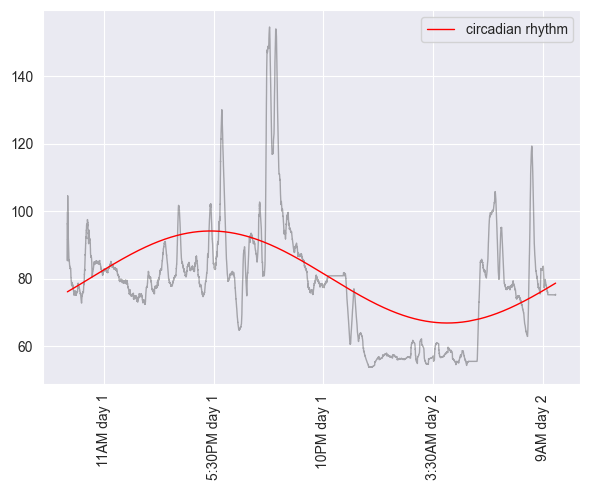

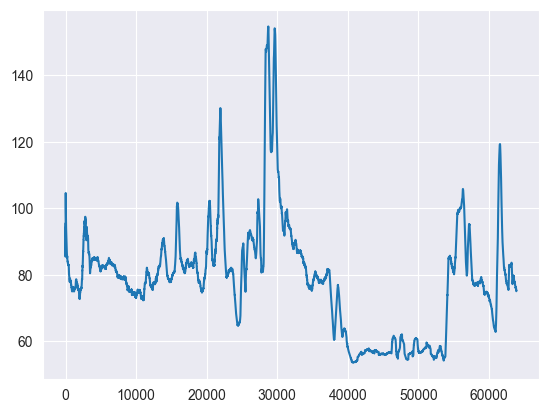

In [6]:
df_user_example = df_rr[df_rr['user']=='user_3'].dropna()
res_single = circadian.fit_sin(df_user_example['timestamp'],df_user_example['hr'].rolling(600,min_periods=1).mean(),plot=True) # fit single component cosinor curves
# print(len(df_user_example['hr']))

df_user_timestamp= res_single["tt"]
res_data = res_single["yy"]
data = pd.DataFrame({"data":df_user_example['hr'].rolling(600,min_periods=1).mean(),"timestamp":df_user_example['datetime']})
# plt.plot(df_user_example["hr"][0:120])

data_pd = data.groupby("timestamp").mean().reset_index()
data_ts = data_pd["timestamp"].copy()
del  data_pd["timestamp"]
index = pd.DatetimeIndex(data_ts)
data_pd.index.freq = '1s'
plt.plot(data_pd)
# data_pd.resample("1S").ffill()
data_pd[:int(len(data_pd) * 0.8)].to_csv("train.csv")
data_pd[int(len(data_pd) * 0.8):].to_csv("test.csv")

# data_pd = data_pd

In [3]:
import torch
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
# 按照0.8 和 0.2 的比例随机划分数据集合
X_train,X_test,Y_train,Y_test = train_test_split(np.array(data_pd[0:60902].index),np.array(list(data_pd["data"][0:60902])), test_size=0.2,shuffle=True)
def load_data():

    return data_pd["data"].to_numpy()

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

In [4]:
dataset = load_data()
print(np.min(dataset),np.max(dataset))
train = dataset[:int(len(dataset) * 0.6)]
val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.8)]
test = dataset[int(len(dataset) * 0.8):len(dataset)]
print(len(train), len(val), len(test))
print(range(len(test) - 24))
m, n = np.max(train), np.min(train)
print((val - n) / (m - n))

53.65892228513414 154.6405882798613
38341 12781 12781
range(0, 12757)
[ 0.08603275  0.08657121  0.08697098 ... -0.02499536 -0.02506158
 -0.02504759]


In [26]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def nn_seq_us(B):
    print('data processing...')
    dataset = load_data()
    # split
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.8)]
    test = dataset[int(len(dataset) * 0.8):len(dataset)]
    print(len(train), len(val), len(test))
    m, n = np.max(train), np.min(train)

    def process(data, batch_size, shuffle):

        load = (data - n) / (m - n)
        seq = []
        # print(load[0:24])
        for i in range(len(data) - 24):
            train_seq = []
            train_label = []

            for j in range(i, i + 24):

                x = [load[j]]
                train_seq.append(x)
            # for c in range(2, 8):
            #     train_seq.append(data[i + 24][c])
            train_label.append(load[i + 24])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        # print(seq[-1])
        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=shuffle, num_workers=0, drop_last=True)

        return seq

    Dtr = process(train, B, True)
    # print(val)
    Val = process(val, B, True)
    Dte = process(test, B, False)

    return Dtr, Val, Dte, m, n

class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection

    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.003
model = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # 单向LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq, (h_0, c_0)) # output(5, 30, 64)
        pred = self.linear(output)  # (5, 30, 1)
        pred = pred[:, -1, :]  # (5, 1)
        return pred


In [35]:

from utils.tools import dotdict
args = dotdict()
args.input_size = 1
args.hidden_size = 64
args.num_layers = 2
args.output_size = 1
args.epochs = 2
args.batch_size = 5
args.num_epochs = 2
args.weight_decay = 0.0001
args.lr = 0.003
args.gamma= 0.1
args.step_size= 1

In [47]:
from tqdm import tqdm
import copy
from torch.optim.lr_scheduler import StepLR
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_val_loss(model, Val, loss_function):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(Val):
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = loss_function(pred, y)
            val_loss += loss.item()
    return val_loss

def train(args, Dtr, Val, path):
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size

    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)

    loss_function = nn.MSELoss().to(device)
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr,
                                     weight_decay=args.weight_decay)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=args.lr,
                                    momentum=0.9, weight_decay=args.weight_decay)
    scheduler = StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
    loss = nn.MSELoss()
    # training
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    for epoch in tqdm(range(args.epochs)):
        train_loss = []
        for (seq, label) in Dtr:
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        # validation

        print('epoch {:03d} train_loss {:.8f}'.format(epoch, np.mean(train_loss)))
        model.train()
    state = {'models': model.state_dict()}
    torch.save(state, path)
path = 'model/lstm.pth'
Dtr, Val, Dte, m, n = nn_seq_us(args.batch_size)
train(args, Dtr, Val, path)

data processing...
38341 12781 12781
[0.37146767 0.28558921 0.26491649 0.26817524 0.27384313 0.3436664
 0.3390641  0.33514459 0.33671173 0.33901377 0.34274944 0.34775655
 0.3514627  0.35566429 0.35752514 0.35835125 0.35229159 0.34271664
 0.3358172  0.33268649 0.33070303 0.3299614  0.33258288 0.35185358]
[0.08603275 0.08657121 0.08697098 0.08770935 0.08850411 0.08935511
 0.0902025  0.09094171 0.09136146 0.09158881 0.09184722 0.09222022
 0.09262195 0.09293833 0.09334856 0.09364132 0.09422589 0.09478998
 0.09520109 0.09587483 0.09658384 0.09693313 0.09727726 0.09743917]
[-0.02499855 -0.02503934 -0.0250631  -0.02510156 -0.0251602  -0.02517583
 -0.0251768  -0.0251768  -0.02517789 -0.02512919 -0.02511882 -0.02514155
 -0.02517233 -0.02517818 -0.02514963 -0.02515408 -0.02511616 -0.02503368
 -0.02509054 -0.02504913 -0.02479904 -0.02453812 -0.02431181 -0.02397828]


 50%|█████     | 1/2 [00:22<00:22, 22.70s/it]

epoch 000 train_loss 0.00874567


100%|██████████| 2/2 [00:46<00:00, 23.06s/it]

epoch 001 train_loss 0.00002328


loading models...
predicting...


100%|██████████| 2551/2551 [00:02<00:00, 881.57it/s] 


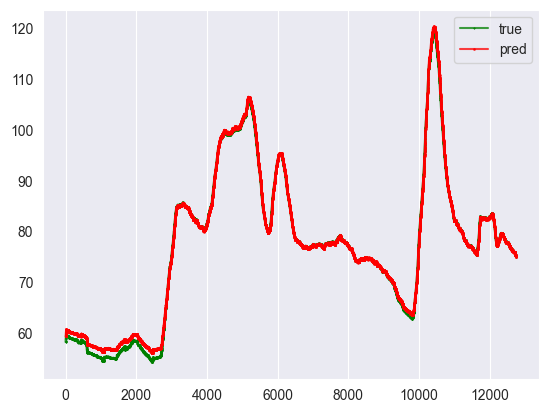

In [50]:
from itertools import chain
from scipy.interpolate import make_interp_spline


def test(args, Dte, path, m, n):
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size

    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)
    # models = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    for (seq, target) in tqdm(Dte):
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    # print('mape:', get_mape(y, pred))
    # plot
    # lenth = len(y)
    # x = [i for i in range(1, 151)]
    # x_smooth = np.linspace(np.min(x), np.max(x), 900)
    # y_smooth = make_interp_spline(x, y[150:300])(x_smooth)
    plt.plot(y, c='green', marker='*', ms=1, alpha=0.75, label='true')

    # y_smooth = make_interp_spline(x, pred[150:300])(x_smooth)
    plt.plot(pred, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    plt.show()
test(args, Dte, path, m, n)